# prepare

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pyproj import Geod
import scipy

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgbm

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Data Clean

In [2]:
def cutomizedCoordinationFix(df):
    df = df.assign(rev=df.dropoff_latitude<df.dropoff_longitude)
    idx = (df['rev'] == 1)
    df.loc[idx,['dropoff_longitude','dropoff_latitude']] = df.loc[idx,['dropoff_latitude','dropoff_longitude']].values
    df.loc[idx,['pickup_longitude','pickup_latitude']] = df.loc[idx,['pickup_latitude','pickup_longitude']].values
    df = df.drop(columns=['rev'])
    return df

def clean_df(df):    
    #reverse incorrectly assigned longitude/latitude values
    df = cutomizedCoordinationFix(df)
    df = df[(df.fare_amount > 0)  & (df.fare_amount <= 500) &
          (df.passenger_count >= 0) & (df.passenger_count <= 8)  &
           ((df.pickup_longitude != 0) & (df.pickup_latitude != 0) & (df.dropoff_longitude != 0) & (df.dropoff_latitude != 0) )]
    
    return df

# Use Featuretools to create feature

In [3]:
import featuretools as ft
print(f"featuretools version is {ft.__version__}")

from featuretools.primitives import TransformPrimitive
from woodwork.column_schema import ColumnSchema
from woodwork.logical_types import Double, LatLong, Datetime, Boolean

2022-11-30 22:32:53,126 featuretools - WARNING    Featuretools failed to load "nlp_primitives" primitives from "nlp_primitives". For a full stack trace, set logging to debug.
2022-11-30 22:32:53,142 featuretools - WARNING    Featuretools failed to load plugin nlp_primitives from library nlp_primitives. For a full stack trace, set logging to debug.
featuretools version is 1.18.0


# featuretools related function

In [8]:
from woodwork.logical_types import Ordinal

def produce_featuretools_entityset(es, df):
    trip_logical_types = {
        'passenger_count': Ordinal(order=list(range(0, 10))), 
        'pickup_latlong': 'LatLong',
        'dropoff_latlong': 'LatLong',
    }

    es.add_dataframe(dataframe_name="trips",
                     dataframe=df,
                     index="id",
                     time_index='pickup_datetime',
                     logical_types=trip_logical_types)

    es.normalize_dataframe(base_dataframe_name="trips",
                           new_dataframe_name="passenger_cnt",
                           index="passenger_count")
    return es


In [13]:
def get_coordination(df):
    df["pickup_latlong"] = df[['pickup_latitude', 'pickup_longitude']].apply(tuple, axis=1)
    df["dropoff_latlong"] = df[['dropoff_latitude', 'dropoff_longitude']].apply(tuple, axis=1)
    df = df.drop(["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"], axis = 1)
    return df

def modelling_features(df):
    df = get_coordination(df)
    #print(df.dtypes)

    es = ft.EntitySet("nyc_taxi_fare")
    with Timer("produce entityset"):
        es = produce_featuretools_entityset(es, df)
    
    cutoff_time = es['trips'][['id', 'pickup_datetime']]

    # calculate feature_matrix using deep feature synthesis
    df, features = ft.dfs(entityset=es,
                      target_dataframe_name="trips",
                      verbose=True,
                      cutoff_time=cutoff_time,
                      approximate='36d',
                      max_depth=3,
                      max_features=200)
    
    return df, es, features

# Pipeline

In [14]:
from utils import Timer
from IPython.display import display

path = "../data/"
TRAIN_PATH = f'{path}/train.csv'
TEST_PATH = f'{path}/test.csv'

cols = [
    'fare_amount', 'pickup_datetime','pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude', 'passenger_count'
]
with Timer("Load test"):
    test = pd.read_csv(TEST_PATH)
    
#sampled_line = 10000000
with Timer(f"Load train full"):
    train = pd.read_csv(TRAIN_PATH, usecols=cols)

print("Raw data")
display(train)

with Timer("Data Wrangling for train"):
    train = clean_df(train)
    
#======= start to use feature tools to enrich =========#
    
with Timer("enrich feature for train"):
    print(f"\n*** before enrich ***")
    print(train.dtypes)
    
    train, es, features = modelling_features(train)
    
    print(f"\n*** after enrich ***")
    print(train.dtypes)
     
print("Before Training")
display(train)


Load test took 0.052030344028025866 sec
Load train full took 78.94500058609992 sec
Raw data


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5000,2009-06-15 17:26:21 UTC,-73.8443,40.7213,-73.8416,40.7123,1
1,16.9000,2010-01-05 16:52:16 UTC,-74.0160,40.7113,-73.9793,40.7820,1
2,5.7000,2011-08-18 00:35:00 UTC,-73.9827,40.7613,-73.9912,40.7506,2
3,7.7000,2012-04-21 04:30:42 UTC,-73.9871,40.7331,-73.9916,40.7581,1
4,5.3000,2010-03-09 07:51:00 UTC,-73.9681,40.7680,-73.9567,40.7838,1
...,...,...,...,...,...,...,...
55423851,14.0000,2014-03-15 03:28:00 UTC,-74.0053,40.7400,-73.9633,40.7626,1
55423852,4.2000,2009-03-24 20:46:20 UTC,-73.9578,40.7655,-73.9516,40.7740,1
55423853,14.1000,2011-04-02 22:04:24 UTC,-73.9705,40.7523,-73.9605,40.7973,1
55423854,28.9000,2011-10-26 05:57:51 UTC,-73.9809,40.7646,-73.8706,40.7740,1


Data Wrangling for train took 11.856753861065954 sec

*** before enrich ***
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object


2022-11-30 17:35:23,093 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:34427', name: 2, status: running, memory: 0, processing: 0>
2022-11-30 17:35:23,190 - distributed.scheduler - WARNING - Communication with worker tcp://127.0.0.1:34427 failed during replication: CommClosedError: in <TCP (closed) ConnectionPool.gather local=tcp://127.0.0.1:56806 remote=tcp://127.0.0.1:34427>: Stream is closed
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
2022-

  produce entityset took 1124.3017299859785 sec
Built 32 features
Elapsed: 2:47:24 | Progress: 100%|██████████

*** after enrich ***
fare_amount                                                              float64
passenger_count                                                         category
DAY(pickup_datetime)                                                    category
HAVERSINE(dropoff_latlong, pickup_latlong)                               float64
MONTH(pickup_datetime)                                                  category
WEEKDAY(pickup_datetime)                                                category
YEAR(pickup_datetime)                                                   category
passenger_cnt.COUNT(trips)                                                 Int64
passenger_cnt.MAX(trips.fare_amount)                                     float64
passenger_cnt.MEAN(trips.fare_amount)                                    float64
passenger_cnt.MIN(trips.fare_amount)                     

,fare_amount,passenger_count,DAY(pickup_datetime),"HAVERSINE(dropoff_latlong, pickup_latlong)",MONTH(pickup_datetime),WEEKDAY(pickup_datetime),YEAR(pickup_datetime),passenger_cnt.COUNT(trips),passenger_cnt.MAX(trips.fare_amount),passenger_cnt.MEAN(trips.fare_amount),...,passenger_cnt.MODE(trips.MONTH(pickup_datetime)),passenger_cnt.MODE(trips.WEEKDAY(pickup_datetime)),passenger_cnt.MODE(trips.YEAR(pickup_datetime)),passenger_cnt.NUM_UNIQUE(trips.DAY(pickup_datetime)),passenger_cnt.NUM_UNIQUE(trips.MONTH(pickup_datetime)),passenger_cnt.NUM_UNIQUE(trips.WEEKDAY(pickup_datetime)),passenger_cnt.NUM_UNIQUE(trips.YEAR(pickup_datetime)),"passenger_cnt.SKEW(trips.HAVERSINE(dropoff_latlong, pickup_latlong))","passenger_cnt.STD(trips.HAVERSINE(dropoff_latlong, pickup_latlong))","passenger_cnt.SUM(trips.HAVERSINE(dropoff_latlong, pickup_latlong))"
id,,,,,,,,,,,,,,,,,,,,,
43310508,30.2000,1,1,9.7563,1,3,2009,0,NaN,NaN,...,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,0.0000
862908,15.0000,1,1,3.1779,1,3,2009,0,NaN,NaN,...,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,0.0000
13073257,4.2000,1,1,0.1956,1,3,2009,0,NaN,NaN,...,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,0.0000
647957,5.8000,2,1,0.7932,1,3,2009,0,NaN,NaN,...,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,0.0000
12655086,14.6000,1,1,3.1802,1,3,2009,0,NaN,NaN,...,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,NaN,NaN,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40210315,24.5000,2,30,4.7709,6,1,2015,7962152,498.0000,11.7878,...,5,5,2009,31,12,7,7,84.2826,45.7522,22333368.0745
13957545,6.0000,2,30,0.8838,6,1,2015,7962152,498.0000,11.7878,...,5,5,2009,31,12,7,7,84.2826,45.7522,22333368.0745
48940597,33.5000,1,30,7.3407,6,1,2015,37263807,500.0000,11.1785,...,3,3,2012,31,12,7,7,83.9376,54.4508,105673650.2258


In [15]:
train.to_parquet("featuretools_default_nyc_taxi.parquet")

In [7]:
train

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,dayofyear,weekday,time,distance,direction
0,4.5000,-73.8443,40.7213,-73.8416,40.7123,1,2009,166,0,1022,1029.6007,167.1927
1,16.9000,-74.0160,40.7113,-73.9793,40.7820,1,2010,5,1,965,8443.4414,21.5739
2,5.7000,-73.9827,40.7613,-73.9912,40.7506,2,2011,230,3,3,1389.1322,-148.8690
3,7.7000,-73.9871,40.7331,-73.9916,40.7581,1,2012,112,5,243,2795.7897,-7.7015
4,5.3000,-73.9681,40.7680,-73.9567,40.7838,1,2010,68,1,425,1998.3378,28.8962
...,...,...,...,...,...,...,...,...,...,...,...,...
55423851,14.0000,-74.0053,40.7400,-73.9633,40.7626,1,2014,74,5,182,4339.8703,54.7851
55423852,4.2000,-73.9578,40.7655,-73.9516,40.7740,1,2009,83,1,1204,1070.1565,28.9918
55423853,14.1000,-73.9705,40.7523,-73.9605,40.7973,1,2011,92,5,1320,5069.4491,9.5518
55423854,28.9000,-73.9809,40.7646,-73.8706,40.7740,1,2011,299,2,305,9369.5665,83.6125


# EvalML Train

In [ ]:
from utils import Timer
import pandas as pd
from utils import Timer
#from sklearn.metrics import mean_squared_error

# with Timer("read train"):
#     train = pd.read_parquet("featuretools_default_nyc_taxi.parquet")

# x = train.drop(columns=['fare_amount'])
# y = train['fare_amount'].values

# def get_split_sets(x, y):
#     from sklearn.model_selection import train_test_split

#     x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=123)
#     return x_train, x_val, y_train, y_val

# with Timer("split train and val"):
#     x_train, x_val, y_train, y_val = get_split_sets(x, y)
#     x_train_save = x_train
#     x_val_save = x_val


def fix_df_types(df):
    Int64_cols = list(n for n, x in zip(df.dtypes.index.to_list(), df.dtypes.to_list()) if x.name == 'Int64')
    df[Int64_cols] = df[Int64_cols].fillna(0).astype('int64')
    return df

def fix_type(type_name):
    return type_name.replace('int64', 'Integer').replace('Int64', 'Integer').replace('float64', 'Double')

  
x_train = fix_df_types(x_train)
x_val = fix_df_types(x_val)
feature_types = dict((n, fix_type(x.name)) for n, x in zip(x_val.dtypes.index.to_list(), x_val.dtypes.to_list()))
print(feature_types)
# looking for right ml pipeline
import evalml
from evalml import AutoMLSearch

automl = AutoMLSearch(X_train=x_train,
                      y_train=y_train,
                      X_holdout=x_val,
                      y_holdout=y_val,
                      problem_type="regression",
                      objective="root mean squared error",
                      train_best_pipeline = False,
                      feature_types = feature_types)
with Timer("search best ml method"):
    automl.search()

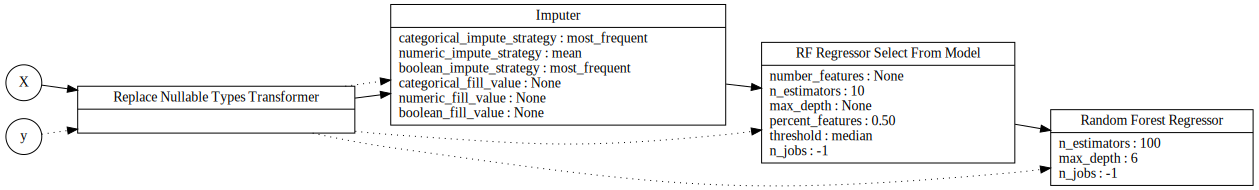

In [22]:
best_pipeline = automl.best_pipeline()
best_pipeline.graph()

In [26]:
automl.train_pipelines(best_pipeline)

# LGBM Train

In [ ]:
from utils import Timer
import pandas as pd
from sklearn.metrics import mean_squared_error
import lightgbm as lgbm
import numpy as np
import re
            
# with Timer("read train"):
#     train = pd.read_parquet("featuretools_default_nyc_taxi.parquet")

# x = train.drop(columns=['fare_amount'])
# y = train['fare_amount'].values

# def get_split_sets(x, y):
#     from sklearn.model_selection import train_test_split

#     x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=123)
#     return x_train, x_val, y_train, y_val

# with Timer("split train and val"):
#     x_train, x_val, y_train, y_val = get_split_sets(x, y)
#     x_train_save = x_train
#     x_val_save = x_val

# def fix_df_types(df):
#     Int64_cols = list(n for n, x in zip(df.dtypes.index.to_list(), df.dtypes.to_list()) if x.name == 'Int64')
#     df[Int64_cols] = df[Int64_cols].fillna(0).astype('int64')
#     return df

# def fix_type(type_name):
#     return type_name.replace('int64', 'Integer').replace('Int64', 'Integer').replace('float64', 'Double')

def fix_column_name(df):
    return df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
  
# x_train = fix_df_types(x_train)
# x_val = fix_df_types(x_val)

x_train = fix_column_name(x_train)
x_val = fix_column_name(x_val)
           
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':1000,
        'num_boost_round': 10000,
        'early_stopping_rounds': 50
    }


lgbm_train = lgbm.Dataset(x_train, y_train, silent=False)
lgbm_val = lgbm.Dataset(x_val, y_val, silent=False)

with Timer("train"):
    model = lgbm.train(params=params, train_set=lgbm_train, valid_sets=lgbm_val, verbose_eval=100)
    
with Timer("predict"):
    pred = model.predict(x_val, num_iteration=model.best_iteration)
    
with Timer("calculate rmse"):
    rmse = np.sqrt(mean_squared_error(y_val, pred))

print('LightGBM RMSE', rmse)

[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 5.607394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9004
[LightGBM] [Info] Number of data points in the train set: 48884359, number of used features: 30
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Start training from score 11.324502
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 4.52344
[200]	valid_0's rmse: 4.47972
[300]	valid_0's rmse: 4.47297
[400]	valid_0's rmse: 4.47072
[500]	valid_0's rmse: 4.46952
[600]	valid_0's rmse: 4.46908


# Poor performance LGBM tree

In [12]:
with Timer("split train and val"):
    x_train, x_val, y_train, y_val = get_split_sets(train)

lgbm_params = {
    'objective': 'regression',
    'boosting': 'gbdt',
    'reg_sqrt': True,
    'learning_rate': 0.03,
    'num_leaves': 1200,
    'max_depth': -1,
    'max_bin': 5000,
    'num_rounds': 1200,
    'early_stopping_round': 50,
    'metric': 'rmse'
}

lgbm_train = lgbm.Dataset(x_train, y_train, silent=False)
lgbm_val = lgbm.Dataset(x_val, y_val, silent=False)

with Timer("train"):
    model = lgbm.train(params=lgbm_params, train_set=lgbm_train, valid_sets=lgbm_val, verbose_eval=100)
    
with Timer("predict"):
    pred = model.predict(x_val, num_iteration=model.best_iteration)
    
with Timer("calculate rmse"):
    rmse = np.sqrt(mean_squared_error(y_val, pred))

print('LightGBM RMSE', rmse)

split train and val took 3.7570005068555474 sec
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.129873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30536
[LightGBM] [Info] Number of data points in the train set: 9000000, number of used features: 12
[LightGBM] [Info] Start training from score 3.177760
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 4.25898
[200]	valid_0's rmse: 4.12228
[300]	valid_0's rmse: 4.08928
[400]	valid_0's rmse: 4.0765
[500]	valid_0's rmse: 4.07053
[600]	valid_0's rmse: 4.06616
[700]	valid_0's rmse: 4.06431
[800]	valid_0's rmse: 4.06246
[900]	valid_0's rmse: 4.06072
[1000]	valid_0's rmse: 4.05996
[1100]	valid_0's rmse: 4.05938
Early stopping, best iteration is:
[1107]	valid_0's rmse: 4.05933
train took 803.9622147129849 sec
predict took 4.348827651701868 sec
calculate rmse

# EDA

In [ ]:
def exploration_features(df):
    """adds features for use in the EDA section"""
    df = shared_features(df)
    df = (
        df
        .assign(
            hour=df.pickup_datetime.dt.hour,
            close_to_airport='No',
            fare_per_km=df.fare_amount*1000/df.distance,
            direction_bucket = pd.cut(df.direction, np.linspace(-180, 180, 37)),

            #small location buckets
            pickup_long_bucket=pd.cut(df.pickup_longitude, bins=2550, labels=False),
            pickup_lat_bucket=pd.cut(df.pickup_latitude, bins=2200, labels=False),
            dropoff_long_bucket=pd.cut(df.dropoff_longitude, bins=2550, labels=False),
            dropoff_lat_bucket=pd.cut(df.dropoff_latitude, bins=2200, labels=False),


            #large location buckets
            pickup_long_bucket_big=pd.cut(df.pickup_longitude, bins=255, labels=False),
            pickup_lat_bucket_big=pd.cut(df.pickup_latitude, bins=220, labels=False),
            dropoff_long_bucket_big=pd.cut(df.dropoff_longitude, bins=255, labels=False),
            dropoff_lat_bucket_big=pd.cut(df.dropoff_latitude, bins=220, labels=False)
        )
        .drop(columns='pickup_datetime')
        .query("0 < distance")
    )

    df.loc[((df['pickup_dist_jfk']<1500) | (df['dropoff_dist_jfk']<1500)), 'close_to_airport'] = 'JFK'
    df.loc[((df['pickup_dist_lga']<1500) | (df['dropoff_dist_lga']<1500)), 'close_to_airport'] = 'LaGuardia'
    df.loc[((df['pickup_dist_nla']<1500) | (df['dropoff_dist_nla']<1500)), 'close_to_airport'] = 'Newark'  
    return df

